# CNNs and transfer learning

## Introduction

In the past lab we have used the high-level API of PyTorch to implement an MLP. We have seen how shifted images produced significantly worse results, while to the human eye the examples are equally recognisable.

In this lab we will use convolutional layers to increase translation invariance of images. We will start with implementing a convolutional model to perform classification on MNIST and then we will load a pretrained model and use transfer learning on a new dataset of fish images.


## Objectives
- Learn to create a simple CNN model in PyTorch
- Use torch cuda device to improve training performance 
- Understand and perform transfer learning using pretrained models

## Getting started

We will first import all necessary modules:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt

## Convolutional neural network

In order to build a CNN we use Convolutional layers from PyTorch. In the case of images we will need 2D convolutions.

## Exercise 1

Implement the following model using PyTorch:

```
- convolutional 1 input channel (grayscale images), 6 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- convolutional 6 input channels, 16 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- flatten
- linear 120 output units
- rectified linear unit
- linear 84 output units
- rectified linear unit
- linear 10 output units
```

**Note:** we must provide the input dimension of the first linear layer. This will depend on how the convolutional and pooling layers have downsampled the input images. By carefully looking at the docs of PyTorch we can compute the output dimensions before the linear layer. The lazy way is: 
- put an arbitrary value
- print the shape of `x` after every operation
- run a forward on a single batch (you may obtain a single batch from a dataloader with `next(iter(my_dataloader))`
- check where it fails and correct the input dimension of that layer  

For now you may simply put your best guess and we will correct it after running the next cell.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1,  out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Flatten(1) is deprecated you can use Flatten()
            nn.Flatten(), 
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
        ### END SOLUTION


    def forward(self, x):
        ### BEGIN SOLUTION
        return self.net(x)
        ### END SOLUTION

model = Net()
print(model)

x = torch.randn((1,1, 28, 28))
model(x).size()

Net(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


torch.Size([1, 10])

## Exercise 2
Create the datasets and data loaders for the MNIST dataset as done in the previous lab. Take the first batch and run a forward of the model correcting the input dimension of the first `Linear` layer.

In [3]:
### BEGIN SOLUTION
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


train_set = torchvision.datasets.MNIST(
    root="data/mnist", # Location of the original file
    train=True,        # creates a dataset for the training set
    download=True,     # Download the data
    transform=transform # transform the data before to be use
)

test_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=transform
)


inputs, y = train_set[0]
### END SOLUTION

output = model(inputs.reshape(1,1,28,28))
print(output)

tensor([[ 0.0761, -0.0622,  0.0172, -0.0748,  0.0329,  0.0917, -0.0150,  0.0244,
          0.0418,  0.0005]], grad_fn=<AddmmBackward0>)


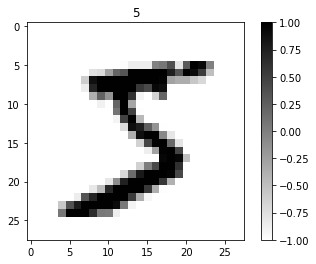

In [4]:
# Shows the first image on the training set
plt.imshow(inputs[0], cmap="gray_r")
plt.colorbar()
plt.title(y)
plt.show()

## Exercise 3

Train the model as done in the previous lab. Given that epochs take longer to compute with these models, we will print the average loss value every 1000 iterations. Write the train function so that every 1000 iterations it prints the average loss over these past 1000 iterations.

In [5]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1):
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            ## BEGIN SOLUTION
            inputs, labels = batch 

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()

            running_loss += loss.item() 
            running_examples += inputs.shape[0]

            if i % 1000 == 999:
                print(f'ep: {epoch: 3d}, it: {i: 5d}, loss: {running_loss/running_examples:.3f}')
                running_loss = 0.
                running_examples = 0

            optimizer.step()

            ## END SOLUTION


def evaluate_model(model, dataloader):
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            ## BEGIN SOLUTION
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ## END SOLUTION

    accuracy = correct/total
    return accuracy

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_model(model, train_loader, optimizer, criterion, n_epochs=2)
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
    

ep:   0, it:   999, loss: 0.116
ep:   0, it:  1999, loss: 0.020
ep:   0, it:  2999, loss: 0.012
ep:   1, it:   999, loss: 0.008
ep:   1, it:  1999, loss: 0.006
ep:   1, it:  2999, loss: 0.006
Accuracy of the network on the test images: 97.5%


We notice that the change in architecture improves the accuracy obtained on the test set. However we also notice the training and testing takes longer. Convolutions are operations that can benefit significantly from GPU processing.

We will now learn how to move the data and operations to the GPU device to take advantage of its benefits.

The first thing to do is to obtain the GPU `device` if available, falling back to the CPU if the GPU is not available. This can be done with the following statement:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Then we may move the `nn.Module` that we want run in GPU:

```
model.to(device)
```

We must also move the data `inputs` and `labels` to the GPU before using them.

```
inputs, labels = inputs.to(device), labels.to(device)
```

**Note:** in Google's Collaboratory environment we may request running the Python kernel on a GPU. To do so go to the Menu > Runtime > Change runtime type. Only use this feature when needed to avoid using unnecessary ressources.

## Exercise 4

Re-train the model, this time on GPU.

In [6]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    ## BEGIN SOLUTION
    model.to(device)
    model.train()
    
    for epoch in range(n_epochs):
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            ## BEGIN SOLUTION
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()

            running_loss += loss.item() 
            running_examples += inputs.shape[0]

            if i % 1000 == 999:
                print(f'ep: {epoch: 3d}, it: {i: 5d}, loss: {running_loss/running_examples:.3f}')
                running_loss = 0.
                running_examples = 0

            optimizer.step()

    ## END SOLUTION

def evaluate_model(model, dataloader, device='cpu'):
    ## BEGIN SOLUTION
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            ## BEGIN SOLUTION
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ## END SOLUTION

    accuracy = correct/total
    return accuracy
    ## END SOLUTION

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the 10000 test images: {accuracy:.1%}')


ep:   0, it:   999, loss: 0.122
ep:   0, it:  1999, loss: 0.024
ep:   0, it:  2999, loss: 0.013
ep:   1, it:   999, loss: 0.009
ep:   1, it:  1999, loss: 0.007
ep:   1, it:  2999, loss: 0.007
Accuracy of the network on the 10000 test images: 97.1%


In this case the speed-up may not be too noticeable because the model is small. But we can now increase the number of convolutional filters without having a large impact on training time.

## Exercise 5

Try changing the number of filters of the first convolution to 16 and the next to 36.

In [7]:
class Net(nn.Module):
    def __init__(self):
        ### BEGIN SOLUTION
        super().__init__()
        self.net = nn.Sequential(
            # The number of filters in a Convolutional layer are the
            # output channels, so for this excercise we only need to change
            # those values.
            nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # The number of filters determine the depth of the output layer.
            # Higher the number of filters, higher is the possibility to learn
            # From complex data, but can result in an overfitting.
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(), 
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )    

    def forward(self, x):
        return self.net(x)

        ### END SOLUTION

model = Net()
x = torch.randn((1,1, 28, 28))
model(x)


tensor([[ 0.0433, -0.0772, -0.0919,  0.0832, -0.1001,  0.0704,  0.0344,  0.0381,
          0.0889, -0.0085]], grad_fn=<AddmmBackward0>)

In [8]:
class Net(nn.Module):
    def __init__(self):
        ### BEGIN SOLUTION
        super().__init__()
        self.net = nn.Sequential(
            # The number of filters in a Convolutional layer are the
            # output channels, so for this excercise we only need to change
            # those values.
            nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # The number of filters determine the depth of the output layer.
            # Higher the number of filters, higher is the possibility to learn
            # From complex data, but can result in an overfitting.
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(), 
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )    

    def forward(self, x):
        return self.net(x)

        ### END SOLUTION

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

ep:   0, it:   999, loss: 0.097
ep:   0, it:  1999, loss: 0.017
ep:   0, it:  2999, loss: 0.010
ep:   1, it:   999, loss: 0.007
ep:   1, it:  1999, loss: 0.005
ep:   1, it:  2999, loss: 0.005
Accuracy of the network on the test images: 97.5%


We will now test whether using CNN allows us to improve performance on the test set of shifted images. 

## Exercise 6
Create a new `test_shifted_set` and `test_shifted_loader` where images are shifted 3 pixels to the right and plot the first image. Use the transforms API of PyTorch (e.g. `transforms.Lambda`).

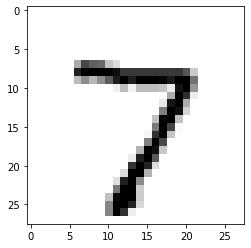

In [9]:
transform = transforms.Compose(
    [
     ### BEGIN SOLUTION
     transforms.ToTensor(),
     transforms.Lambda(lambda img: img[:,:,3:]),
     transforms.Lambda(lambda img: torch.nn.functional.pad(img,(3,0,0,0))),
     transforms.Normalize((0.5,), (0.5,))
     ### END SOLUTION
    ])

test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)

test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)

plt.imshow(test_shifted_set[0][0][0], cmap='gray_r')
plt.show()

## Exercise 7

Test the performance of the previously trained model on the new test set.

In [10]:
test_shifted_set[0][0][0].size()

torch.Size([28, 28])

In [11]:
### BEGIN SOLUTION
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy = evaluate_model(model, test_shifted_loader, device=device)

### END SOLUTION

print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Accuracy of the network on the test images: 97.5%


## [Optional] Exercise 8

Compare the performance of an MLP vs CNN for shifts of increasing number of pixels.

## [Optional] Exercise 9

Propose a solution (and optionally implement it) to make the models even more robust to shifts?

Your reponse here

# Transfer learning

It is quite rare that we implement new models from scratch, specially when our target dataset is small.

We will often perform what is known as transfer learning: **start from well-established models pre-trained on large quantities of similar data**. For example, for natural image related tasks we will often start from a `ResNet` or `MobileNet`, whose weights have been trained on a classification task on ImageNet.

The model chosen to base our work on is often referred to as the **backbone**.

Depending on the task the pre-trained model may not be directly usable. Even when performing a classification task, the classes may not be the same, even the number of classes may vary. Therefore, for sure the output layer of the model may need to be modified (and re-trained).

PyTorch provides pre-trained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) and from [PyTorch Hub](https://pytorch.org/hub/). Throughout this lab we will use the PyTorch Hub way.

For instance to download a [ResNet-18 model](https://pytorch.org/hub/pytorch_vision_resnet/) we would do:

```
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
```

To practice the methodology of transfer learning, we will use a small dataset provided by [here](https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/)

We will do the following steps:
1. Download the data and untar it
2. Create a dataset object using [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)
3. Split the dataset into train and test using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Train several models on the data
    1. A simple custom made CNN model
    2. A ResNet-18 without pretrained weights
    3. A ResNet-18 with pretrained weights training only the last layer

When splitting the data into train and test we will do a 80% / 20% ratio per each class (stratified). <!--We notice in the dataset that consecutive images seem to be extracted often from the same video segment, therefore we will split data in consecutive chunks instead of shuffling it (random split).-->

## Exercise 10
Download the data and untar it. Using `wget` (run with the `-nc` flag to avoid redownloading unnecessarily multiple times) and `tar`. Bash commands in Colab and Jupyter must be preceded by a `!`.

In [12]:
### BEGIN SOLUTION
!wget -nc https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
### END SOLUTION

File ‘fishRecognition_GT.tar’ already there; not retrieving.



In [13]:
!tar xf fishRecognition_GT.tar

tar: A lone zero block at 997875


## Exercise 11
Create a `torchvision.datasets.ImageFolder` for the full fish recognition dataset and plot the first example.

In [14]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=[0.4781, 0.6127, 0.5838], std=[0.2516, 0.3121, 0.3172])
    ]
    )

### BEGIN SOLUTION
full_set = torchvision.datasets.ImageFolder(
    root = "fish_image",
    transform = transform
    )
### END SOLUTION

full_set.classes = [
                    'Dascyllus reticulatus',
                    'Plectroglyphidodon dickii',
                    'Chromis chrysura',
                    'Amphiprion clarkii',
                    'Chaetodon lunulatus',
                    'Chaetodon trifascialis',
                    'Myripristis kuntee',
                    'Acanthurus nigrofuscus',
                    'Hemigymnus fasciatus',
                    'Neoniphon sammara',
                    'Abudefduf vaigiensis',
                    'Canthigaster valentini',
                    'Pomacentrus moluccensis',
                    'Zebrasoma scopas',
                    'Hemigymnus melapterus',
                    'Lutjanus fulvus',
                    'Scolopsis bilineata',
                    'Scaridae',
                    'Pempheris vanicolensis',
                    'Zanclus cornutus',
                    'Neoglyphidodon nigroris',
                    'Balistapus undulatus',
                    'Siganus fuscescens'  	
]

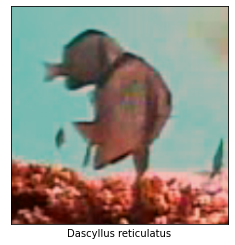

In [15]:
### BEGIN SOLUTION
image, label = full_set[0]

# Convert the image from a tensor to a Numpy array
image = image.numpy()

# Transpose the image to use the Height, then width and then the channels
image = image.transpose((1, 2, 0))
# Un-normalize the image
image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
plt.imshow(image)
### END SOLUTION

plt.xticks([])
plt.yticks([])
plt.xlabel(full_set.classes[label])
plt.show()

In [16]:
image.shape

(224, 224, 3)

## Exercise 12

Using the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the labels from `full_set.targets` perform a stratified random split.

Then create the two new datasets `train_set` and `test_set` using [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)

In [17]:
from sklearn.model_selection import train_test_split

labels = list(full_set.targets)
indices = np.arange(len(labels))

# Random splits
### BEGIN SOLUTION
from torch.utils.data.dataset import Subset
#train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=list(map(lambda x: x[1], full_set.samples)))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)

# Create the train and test sets
train_set = Subset(full_set, train_indices)
test_set = Subset(full_set, test_indices)

### END SOLUTION

In [18]:
print(len(train_set))
print(len(test_set))

21896
5474


## Exercise 13

Compute on a batch of 500 random samples the mean and std deviation for each of the RGB channels. Set these in the `Normalize` transform of the full dataset of the previous cells in order to obtain a normalized version of the dataset.

In [19]:
loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True, num_workers=1)

### BEGIN SOLUTION


mean = 0
std = 0

for i, (batch, _) in enumerate(loader):
    mean += torch.mean(batch, dim=(0, 2, 3))
    std += torch.std(batch, dim=(0, 2, 3))

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ]
    )

### END SOLUTION

In [20]:
print(mean)
print(std)

tensor([-0.7104, -0.3626, -0.4002])
tensor([44.6482, 44.7913, 44.6414])


## Exercise 14

Before tackling transfer learning with an existing model, we will revisit the simple CNN and training procedure we built for MNIST earlier in this lab and make a few modifications.

1. We must first adapt the input to 3 channels (RGB)
2. Adapt the output of the network to the number of classes in our task
3. Increase the number of convolutional layers to 3 (we have larger images) with number of filters `[6, 16, 32]`
4. Adapt the number of inputs of the first fully connected layer
5. Increase the batch size to `64` to improve training time

In [21]:
class Net(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, n_classes):
        ### BEGIN SOLUTIO
        super().__init__()
        self.n_classes = n_classes
        self.net = nn.Sequential(
            # The number of filters in a Convolutional layer are the
            # output channels, so for this excercise we only need to change
            # those values.
            nn.Conv2d(in_channels=3,  out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # The number of filters determine the depth of the output layer.
            # Higher the number of filters, higher is the possibility to learn
            # From complex data, but can result in an overfitting.
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(), 
            nn.Linear(18432, 256),
            nn.ReLU(),
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, self.n_classes)
        )    

    def forward(self, x):
        return self.net(x)
    ### END SOLUTION

def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    ### BEGIN SOLUTION
    model.to(device)
    model.train()
    
    for epoch in range(n_epochs):
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            ## BEGIN SOLUTION
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()

            running_loss += loss.item() 
            running_examples += inputs.shape[0]

            if i % 1000 == 999:
                print(f'ep: {epoch: 3d}, it: {i: 5d}, loss: {running_loss/running_examples:.3f}')
                running_loss = 0.
                running_examples = 0

            optimizer.step()
    ### END SOLUTION

def evaluate_model(model, dataloader, device='cpu'):
    ### BEGIN SOLUTION
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            ## BEGIN SOLUTION
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ## END SOLUTION

    accuracy = correct/total
    return accuracy
    ### END SOLUTION

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(len(full_set.classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Accuracy of the network on the test images: 88.9%


In [22]:
full_set.classes

['Dascyllus reticulatus',
 'Plectroglyphidodon dickii',
 'Chromis chrysura',
 'Amphiprion clarkii',
 'Chaetodon lunulatus',
 'Chaetodon trifascialis',
 'Myripristis kuntee',
 'Acanthurus nigrofuscus',
 'Hemigymnus fasciatus',
 'Neoniphon sammara',
 'Abudefduf vaigiensis',
 'Canthigaster valentini',
 'Pomacentrus moluccensis',
 'Zebrasoma scopas',
 'Hemigymnus melapterus',
 'Lutjanus fulvus',
 'Scolopsis bilineata',
 'Scaridae',
 'Pempheris vanicolensis',
 'Zanclus cornutus',
 'Neoglyphidodon nigroris',
 'Balistapus undulatus',
 'Siganus fuscescens']

We will now create two utility function to help us visualize the outputs of an image classification model.

## Exercise 15

Create a function that takes an image, a model and list of classes and plots the image and a horizontal bar plot (using [`plt.barh`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)) showing the probabilities assigned to the top 10 predicted classes (using [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html?highlight=topk#torch.topk)). Test it on the first image of the test set and using previous trained model.

**Note**: think of bringing back to the cpu and converting to numpy `my_np_array = my_torch_tensor.cpu().numpy()` torch tensors that are in the GPU.

In [23]:
def viz_image(image, model, classes, top=5, device='cpu'):
    assert image.ndim == 3, "Images are expected to have 3 dimensions: channels x height x width"
    was_training = model.training
    model.eval()

    with torch.no_grad():
        ### BEGIN SOLUTION
        image = image.unsqueeze(0)
        image = image.to(device)
        output = model(image)
        probs, preds = torch.topk(torch.softmax(output, dim=1), k=top)
        probs, preds = probs.cpu().numpy(), preds.cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

    plt.figure(figsize=(5, 2))
    ax = plt.gca()
    ax.invert_yaxis()
    ax.barh(np.arange(top), probs[0], align='center')
    ax.set_yticks(np.arange(top))
    ax.set_yticklabels([classes[pred] for pred in preds[0]])
    ax.set_xlim(0, 1)
    plt.show()
        ### END SOLUTION

    #plt.tight_layout()
    model.train(was_training)

image, label = test_set[0]
viz_image(image, model, full_set.classes, device=device)

RuntimeError: ignored

<Figure size 360x360 with 0 Axes>

In [27]:
image.size()

torch.Size([3, 224, 224])

## Exercise 16

Next we will visualize a batch of images and the class predicted by the model with it's probability in parentheses as their `xlabel`.
The function will also return the probabilites of all classes predicted for each image (tensor of `torch.float` with shape `(N, 1000)` where `N` is the number of images in the batch) and the class predicted by the model for each image (tensor of `torch.long` with shape `(N)`).

**Hint**: for create a grid of images consider the following snippet

```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

**Note**: Normalize the pixels of each image between 0 and 1 before plotting it to obtain natural colors. Remember we need to do this, because each image was previously normalized to mean 0 and stddev 1 in order to be fed in the expected way by the model.

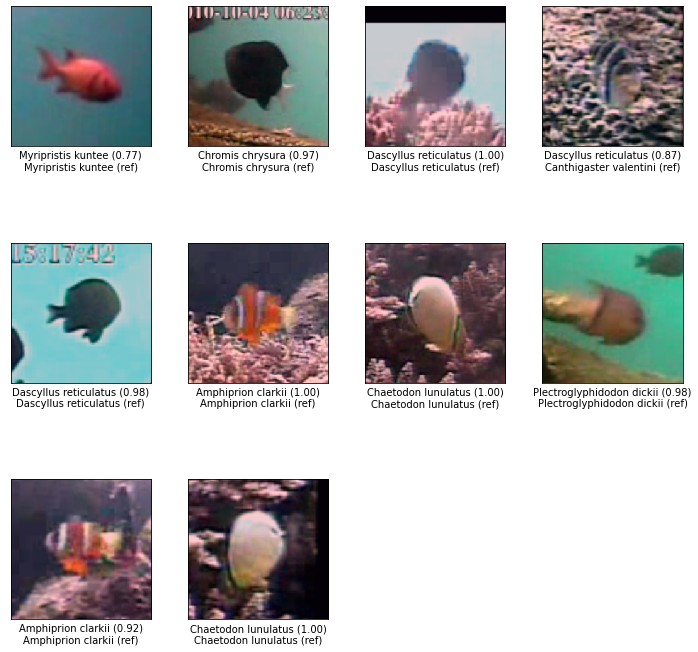

In [ ]:
def viz_image_batch(images, model, classes, top=5, device='cpu', labels=None):
    assert images.ndim == 4, "Images are expected to have 4 dimensions: batch index x channels x height x width"
    model.to(device)

    was_training = model.training
    model.eval()

    with torch.no_grad():
        ### BEGIN SOLUTION
        ### END SOLUTION

    plt.tight_layout()
    model.train(was_training)
    
    return probs, max_class

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
viz_image_batch(images, model, full_set.classes, labels=labels, device=device)

# ResNet model

ResNets are a family of models that have been popularized by their performance in image classification tasks. We will start by downloading a [ResNet18 model](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (a ResNet model composed of 18 layers). Other variants exist with varying number of layers: `resnet34`, `resnet50`, `resnet101`, `resnet152`.

When using an existing model with our particular task, we must first ensure that the inputs of the model are correctly matched.
- The images must have a size compatible with the model

In the case of resnet18, it expects images of size 224x224. In Exercise 11 we had created our datasets for the underwater images in a way that images were scaled (and cropped when necessary) to this size. 

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ...
    ]
```
- The images must have been normalised in an equal (or similar) way

In [torchvision documentation](https://pytorch.org/vision/stable/models.html#:~:text=All%20pre%2Dtrained,0.229%2C%200.224%2C%200.225%5D) we find that the models expect images to be normalized with zero mean and standard deviation of 1.  For the natural images in ImageNet, this corresponds to the following transform:

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
```

However in this lab we have recomputed the statistics of a subsample of our data, since underwater images may have significantly different statistics. 

- The output of the model may need to be modified to match our class set

At first we will not change the output, however the following exercises will require changing the final layer of the model to adapt to our own class set.

## Exercise 17
We will start by downloading a pre-trained `resnet18` and visualizing how it classifies our own images into the ImageNet classes.
**Note**: in order to show the class labels with which it was trained, we could download ImageNet using [`torchvision.datasets.ImageNet`](https://pytorch.org/vision/stable/datasets.html#imagenet) and access the `.classes` attribute of the dataset. However this would take a long unnecessary time and bandwidth, since only the labels are needed. PyTorch is currently revisiting the API of pretrained models ([see here](https://github.com/pytorch/vision/pull/4610)) to solve this and other issues. In the meantime we can download the class list from [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).  

In [28]:
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-01-12 18:19:37--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-01-12 18:19:37 (93.2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [29]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]

print(len(imagenet_classes))

1000


In [31]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
#viz_image_batch(images, model, imagenet_classes, device=device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Exercise 18

Comment on the results.


Your response here.

We are now going to explore different settings of reusing the resnet-18 model. We will start with a non-pretrained model, by initialising the weights randomly and training all layers using the standard training loop that we did before.

To achieve this our first step is to **replace the output layer** in order to output logits for the correct number of classes (those found in our data).

We will first print the resnet model and identify the last layer.

## Exercise 19

Print a non-pretrained resnet18 model and identify the name of the output layer.

In [37]:
### BEGIN SOLUTION
print(model)
### END SOLUTION

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`fc` stands for Fully Connected, and it is the last layer in the model.

In order to replace it we must first remember it's input dimensionality, which can be obtained using `fc.in_features`.

## Exercise 20

Replace the `fc` layer of the vanilla resnet-18 by another `Linear` layer with as many outputs as classes in our fish dataset. Train the resulting model for 2 epochs and show the obtained accuracy.

In [41]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

### BEGIN SOLUTION
model.fc = nn.Linear(in_features=512, out_features=len(full_set.classes), bias=True)
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy of the network on the test images: 89.3%


## Exercise 21

We will now try to leverage the large amount of natural imaging data from ImageNet, by using as backbone a pretrained resnet18 as starting point for training.


In [43]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

### BEGIN SOLUTION
model.fc = nn.Linear(in_features=512, out_features=len(full_set.classes), bias=True)
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Accuracy of the network on the test images: 97.7%


## Exercise 22
In some situations it may be faster and better in terms of acheived accuracy, to only train the last layer, while letting all other layers with their pretrained weights. To freeze a layer you may simply set the `require_grad` attribute of its parameters to `False`.

Sometimes it is still beneficial to perform an additional training phase in which all weights are updated for a couple of epochs. This is known as **fine tuning**. In this exercise we will only be training the inserted layer.

Implement this method and visualize the results on the first batch of test.

**Note**: You may iterate over all parameters of a model calling its `.parameters()` method.

**Note**: Make sure to not freeze the latest layer that you added.


In [42]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    
### BEGIN SOLUTION
model.fc = nn.Linear(in_features=512, out_features=len(full_set.classes), bias=True)
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the test images: 97.8%


## Exercise 23

Visualize the first batch of 16 images and it's predicted class in test.

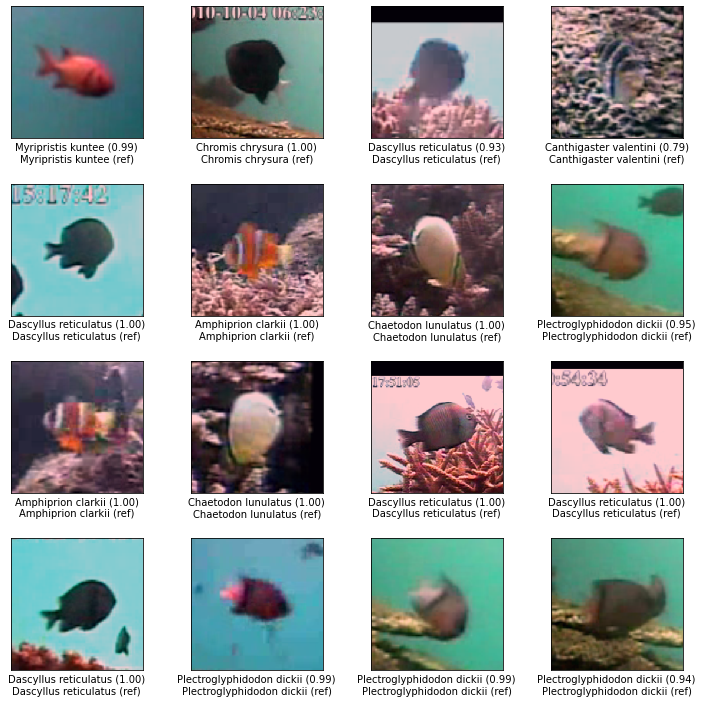

In [ ]:
### BEGIN SOLUTION
### END SOLUTION

## (optional) Exercise 24

Try with one (or all) of the following backbones: [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/), [`VGG`](https://pytorch.org/hub/pytorch_vision_vgg/), [`MobileNetV2`](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

In [ ]:
### BEGIN SOLUTION
### END SOLUTION

## (optional) Exercise 25

Perform fine tuning on one (or more) of the models we have done.

In [ ]:
### BEGIN SOLUTION
### END SOLUTION